In [9]:
# import libraries
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from scipy import stats

In [10]:
# function to read colvar file
def read_colvar(file_name):
    with open(file_name) as f:
        first_line = f.readline()
    fl = first_line[10:-1]
    names = fl.split()
    df = pd.read_csv(file_name,delim_whitespace=True, names=names, comment='#')
    return df

In [11]:
# import data
df = read_colvar('histo/chen_forward/phos/COLVAR')

In [13]:
# checking column titles
df.columns

Index(['time', 'K3.min', 'K4.min', 'K12.min', 'K15.min', 'K32.min', 'K42.min',
       'K122.min', 'K152.min', 'RK16.min', 'RK17.min', 'RK162.min',
       'RK172.min', 'R16.min', 'R17.min', 'R162.min', 'R172.min', 'd', 'YY',
       'YI', 'YL', 'IY', 'II', 'IL', 'LY', 'LI', 'LL', 'IONCL1', 'IONCL2',
       'rg1', 'rg2', 'uwall.bias', 'uwall.force2', 'pbmetad.bias'],
      dtype='object')

In [58]:
# function for reweighting 2D histogram
def HIST_2D(CV1, CV2, weights, temp, bins=50):
    # Calculate weights from pb bias
    kbT = (0.0083144621)*temp
    xmin=CV1.min()
    xmax=CV1.max()
    ymin=CV2.min()
    ymax=CV2.max()
    
    p, cv1, cv2 = np.histogram2d(CV1, CV2, bins=bins, range=([xmin,xmax], [ymin,ymax]), weights=weights,
                                 normed=True)
    
    p = p.transpose()
    
    cv1 = cv1[:-1]
    cv2 = cv2[:-1]
    
    return cv1, cv2, p

In [63]:
# function for reweighting 2D KDE
def KDE_2D(CV1, CV2, weights, bw, temp, xmin, xmax, ymin, ymax, num_samples=25): 
    kbT = (0.0083144621)*temp #kj/mol K
    
    samples=np.array([CV1,CV2])
    
    #print(samples.shape, weights.shape)
    
    pdf = stats.gaussian_kde(samples, weights=weights, bw_method=bw) 
    
    x = np.linspace(xmin, xmax, num_samples)
    y = np.linspace(ymin, ymax, num_samples)
    xx, yy = np.meshgrid(x, y)
    
    p = pdf((np.ravel(xx), np.ravel(yy)))
    zz = np.reshape(p, xx.shape)
    return xx, yy, zz


In [ ]:
# Calculate weights from pb bias
temp = 300
kbT = (0.0083144621)*temp

v = df['pbmetad.bias']
w = np.exp((v)/kbT)
w_norm = w/np.sum(w)
weights = np.array(w_norm, np.float)

# Variables 
bw=0.05
temp=300
kj_to_kcal=1/4.184

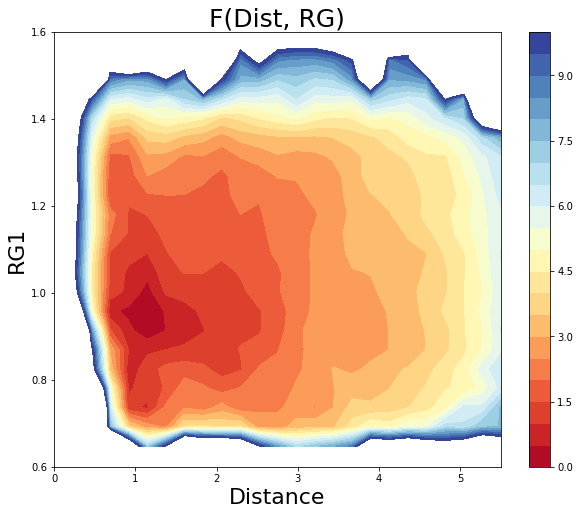

In [73]:
CV1 = (df['d'])
CV2 = (df['rg1'])

# reweighted kde
xx, yy, zz = KDE_2D(CV1, CV2, weights, bw, temp, xmin=CV1.min(), xmax=CV1.max(), 
                    ymin=CV2.min(), ymax=CV2.max(), num_samples=25)
f = -kbT*np.log(zz)
f = f - f.min()

# plot
levels = np.linspace(0,10,21,endpoint=True)
fig=plt.figure(figsize=(10,8)) 
plt.contourf(xx, yy, f*kj_to_kcal, levels, cmap="RdYlBu")
cbar = plt.colorbar(format='%.01f')
plt.xlabel('Distance', fontsize=22)
plt.xlim(0,5.5)
plt.ylabel('RG1', fontsize=22)
plt.ylim(0.6,1.6)
plt.title('F(Dist, RG)', fontsize=25)
plt.show()
plt.show()

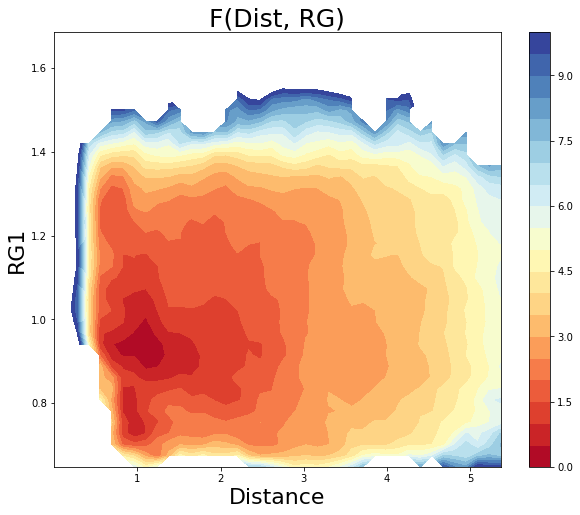

In [70]:
# reweighted histogram
xx2, yy2, p2 = HIST_2D(CV1, CV2, weights, temp, bins=40)
f2 = -kbT*np.log(p2)
f2 = f2 - f2.min()

fig=plt.figure(figsize=(10,8)) 
plt.contourf(xx2, yy2, f2*kj_to_kcal, levels, cmap="RdYlBu")
cbar = plt.colorbar(format='%.01f')
plt.xlabel('Distance', fontsize=22)
plt.ylabel('RG1', fontsize=22)
plt.title('F(Dist, RG)', fontsize=25)
plt.show()